## 데이터 탐색의 목적
1. 데이터가 어떤 식으로 구성된지 확인하고 분석의 방향을 결정 
2. 사용자와 아이템의 특성을 파악하고 좋은 피쳐와 아이디어를 발굴 

In [1]:
import pickle
import pandas as pd
import numpy as np
import os, sys, gc 
from plotnine import *
import plotnine

from tqdm import tqdm_notebook
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import re
from matplotlib.ticker import PercentFormatter
import datetime
from math import log # IDF 계산을 위해

In [3]:
%config InlineBackend.figure_format = 'retina'
mpl.font_manager._rebuild()

fontpath = '../input/t-academy-recommendation/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9).get_name()

mpl.pyplot.rc('font', family=font)
plt.rc('font', family=font)
plt.rcParams['font.family'] = font

In [4]:
warnings.filterwarnings(action='ignore')

## 데이터 로드

In [7]:
path = "../input/t-academy-recommendation/"
print(os.listdir(path))

['predict', 'users.json', 'figure', 'metadata.json', 'read', 'read_rowwise.csv', 'data.0', 'NanumBarunGothic.ttf', 'magazine.json']


데이터의 종류는 크게 5가지로 분류가 가능합니다. 하지만, 메타 데이터의 magazine_id와 Magazine데이터의 id와 매핑되는 등 컬럼명이 조금 다른 점을 볼 수 있습니다. 해당 사항에 유의하면서 각 파일별로 어떠한 특성을 가지고 있는 지 살펴보겠습니다. 

In [20]:
# 하나의 리스트로 반환하는 코드 
def chainer(s):
    return list(itertools.chain.from_iterable(s))

In [8]:
# pd.read_json : json 형태의 파일을 dataframe 형태로 불러오는 코드 
magazine = pd.read_json(path + 'magazine.json', lines=True) # lines = True : Read the file as a json object per line.
metadata = pd.read_json(path + 'metadata.json', lines=True)
users = pd.read_json(path + 'users.json', lines=True)

json 파일의 경우는 pd.read_json을 이용해서 쉽게 불러왔습니다. 하지만, read의 데이터는 파일명이 "시작일_종료일" 형태로 제공되었고 파일의 갯수도 3600개로 많습니다. 그렇기에 경로내에 있는 파일을 한번에 불러와서 하나의 파일로 합치는 작업이 필요합니다. 

In [9]:
import itertools
from itertools import chain
import glob
import os 

In [14]:
read_rowwise = pd.read_csv(path + "read_rowwise.csv")

In [15]:
%%time 
# article_id가 없는 경우 삭제 
read_rowwise = read_rowwise[read_rowwise['article_id'] != ''].reset_index(drop=True)

# 읽은날짜와 시간 추출 
read_rowwise['dt'] = read_rowwise['from'].astype(str).apply(lambda x: x[0:8]).astype(int)
read_rowwise['hr'] = read_rowwise['from'].astype(str).apply(lambda x: x[8:10]).astype(int)
read_rowwise['read_dt'] = pd.to_datetime(read_rowwise['dt'].astype(str).apply(lambda x: x[0:4] + '-' + x[4:6] + '-' + x[6:8]))

read_rowwise['author_id'] = read_rowwise['article_id'].apply(lambda x: str(x).split('_')[0])

In [16]:
read_rowwise[read_rowwise['user_id'] == '#0000d1188f75d0b0ea7a8e23a2b760e5']

,from,to,user_id,article_id,dt,hr,read_dt,author_id
688770,2018100421,2018100422,#0000d1188f75d0b0ea7a8e23a2b760e5,@hyunilikes_156,20181004,21,2018-10-04,@hyunilikes
688771,2018100421,2018100422,#0000d1188f75d0b0ea7a8e23a2b760e5,NaN,20181004,21,2018-10-04,nan


In [17]:
read_rowwise[read_rowwise['user_id'] == '#0000eea6d339abfd02ed590bc451fc63']

,from,to,user_id,article_id,dt,hr,read_dt,author_id
20086077,2019020114,2019020115,#0000eea6d339abfd02ed590bc451fc63,@sucopy_182,20190201,14,2019-02-01,@sucopy
20086078,2019020114,2019020115,#0000eea6d339abfd02ed590bc451fc63,NaN,20190201,14,2019-02-01,nan


두번째로 발견한 이유는 시간이 흐름에 따라서 사용자의 선호가 바뀔 수 있습니다. 아래의 사용자를 보면 초기에 구독했던 작가들은 많으나 시간이 지나면서 읽지 않고 가장 최근 한달에는 구독하지 않은 작가들의 글을 더 많이 읽는 모습을 볼 수 있습니다. (구독하는 작가의 이름만 표시했습니다. )

In [21]:
following_cnt_by_user = users['following_list'].map(len)
following_rowwise = pd.DataFrame({'user_id': np.repeat(users['id'], following_cnt_by_user),
                             'author_id': chainer(users['following_list'])})

following_rowwise.reset_index(drop=True, inplace=True)

# 구독하는 작가의 글을 읽는 비율 vs 그렇지 않은 작가의 글을 읽는 비율 
following_rowwise['is_following'] = 1
read_rowwise = pd.merge(read_rowwise, following_rowwise, how='left', on=['user_id', 'author_id'])

del following_rowwise
gc.collect()

78

In [22]:
user_id = '#a87e970972364bb14a542f57b0933db9'
read_user = read_rowwise[read_rowwise['user_id'] == user_id]
read_user = read_user.groupby(['read_dt', 'is_following', 'author_id'])['author_id'].agg({'count'}).reset_index()

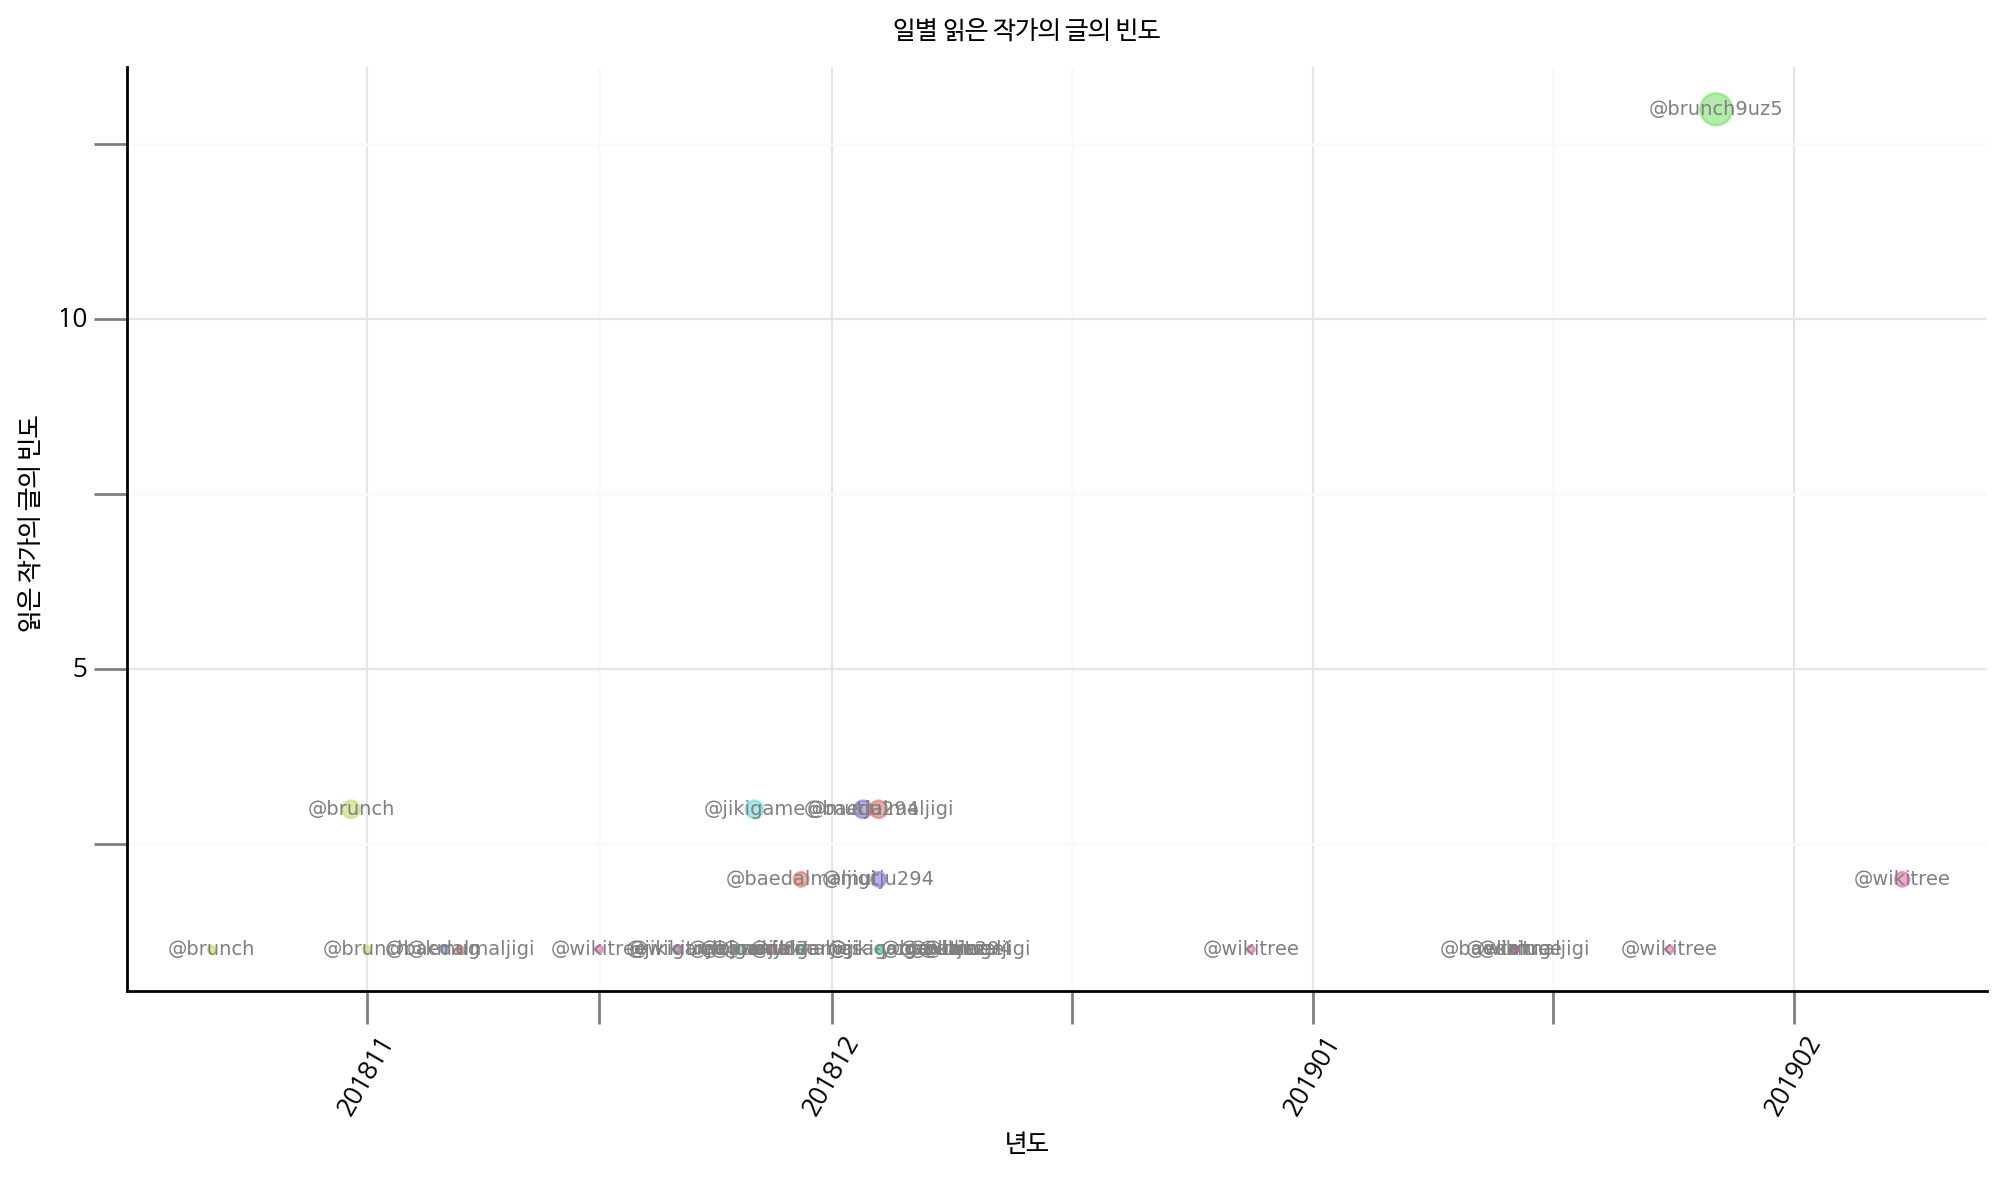

<ggplot: (8730264475605)>

In [23]:
from mizani.breaks import date_breaks
from mizani.formatters import date_format

(ggplot(data=read_user)
    + geom_point(aes(x='read_dt', y='count', color='author_id', size='count'), alpha = 0.5, show_legend=False)
    + geom_text(aes(x='read_dt', y='count', label='author_id'), color='grey', 
               data = read_user[read_user['is_following'] == 1], size=7)
    + scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%Y%m'))
    + theme_minimal()
    + ggtitle("일별 읽은 작가의 글의 빈도")
    + labs(x="년도", y="읽은 작가의 글의 빈도") 
    + theme(text = element_text(fontproperties=fm.FontProperties(fname=fontpath, size=9)),
         axis_text_x = element_text(angle=60, color='black'),
         axis_text_y = element_text(color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(12,6))
 )

위를 통해 판단할 수 있는 정보는 **추천시에 해당 정보들을 토대로 시간에 따라서 사용자의 선호가 바뀐 것은 아닌지, 구독한 작가만의 글을 읽는 게 신뢰할 만한지에 대해 정확히 따져봐야 합니다.**

## 데이터 탐색 - metadata

In [24]:
metadata.head()

,magazine_id,user_id,title,keyword_list,display_url,sub_title,reg_ts,article_id,id
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782
1,12081,@kohwang56,[시] 서러운 봄,"[목련꽃, 아지랑이, 동행]",https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81
2,0,@hannahajink,무엇을 위해,[],https://brunch.co.kr/@hannahajink/4,무엇 때문에,1447997287000,4,@hannahajink_4
3,16315,@bryceandjuli,싫다,"[감정, 마음, 위로]",https://brunch.co.kr/@bryceandjuli/88,,1491055161000,88,@bryceandjuli_88
4,29363,@mijeongpark,Dubliner#7,"[유럽여행, 더블린, 아일랜드]",https://brunch.co.kr/@mijeongpark/34,#7. 내 친구의 집은 어디인가,1523292942000,34,@mijeongpark_34


In [25]:
from datetime import datetime 
metadata['reg_datetime'] = metadata['reg_ts'].apply(lambda x : datetime.fromtimestamp(x/1000.0))
metadata.loc[metadata['reg_datetime'] == metadata['reg_datetime'].min(), 'reg_datetime'] = datetime(2090, 12, 31)
metadata['reg_dt'] = metadata['reg_datetime'].dt.date
metadata['type'] = metadata['magazine_id'].apply(lambda x : '개인' if x == 0.0 else '매거진')
metadata['reg_dt'] = pd.to_datetime(metadata['reg_dt'])

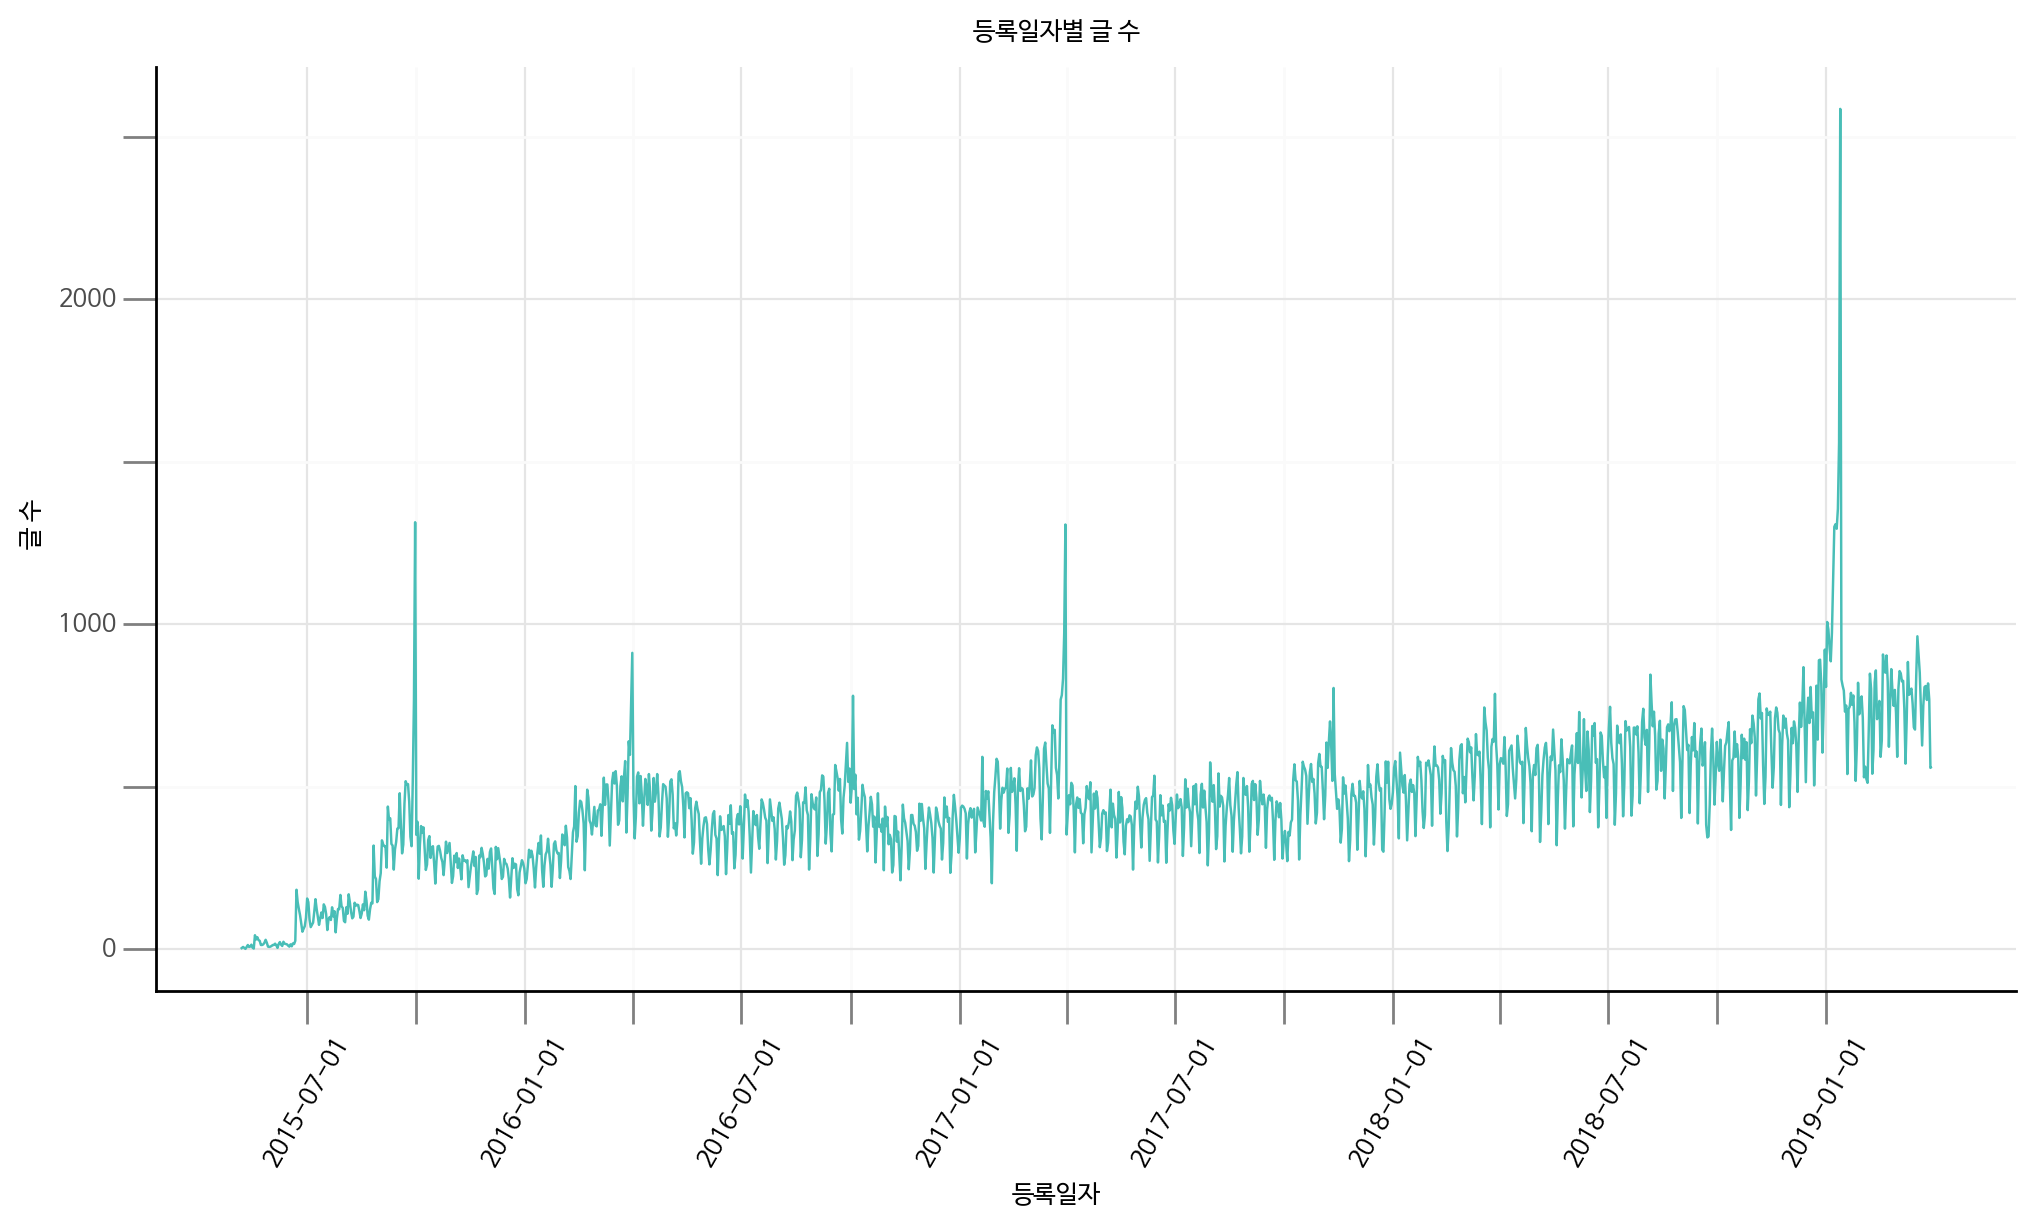

<ggplot: (8730255264381)>

In [26]:
read_cnt_by_reg_dt = pd.DataFrame(metadata.groupby('reg_dt')['article_id'].count()).reset_index()
read_cnt_by_reg_dt = read_cnt_by_reg_dt.iloc[:-1]

(ggplot(data=read_cnt_by_reg_dt)
    + geom_line(aes(x='reg_dt', y='article_id'), colour = '#49beb7')
    + theme_minimal()
    + ggtitle("등록일자별 글 수")
    + labs(x="등록일자", y="글 수") 
    + theme(text = element_text(fontproperties=fm.FontProperties(fname=fontpath, size=9)),
         axis_text_x = element_text(angle=60, color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(12,6))
 )

등록일자별 글의 수를 보면 2015년도 7월 1일을 기점으로 증가하는 추세이고, 주기적으로 증가했다가 감소하는 모습을 볼 수 있습니다. 그리고 1년을 주기로 1번정도 피크를 보이는 모습을 보입니다. 특히, 2019년도 1월 근방에는 엄청나게 뛰는데 해당 이유를 한번 살펴보겠습니다. 

https://brunch.co.kr/brunchbookproject/7 먼저, 해당 이유는 브런치북 출판 프로젝트의 결과입니다. 브런치에서는 단순 글만 쓰는게 아니라 매거진, 위클리 연재등의 다양한 형태의 글이 존재합니다. 해당 날짜는 브런치북 출판 프로젝트의 마감날로서 사람들이 많이 신청한 것으로 판단됩니다. 

이번에는 2019년도 3월의 데이터만을 뽑아서 주기별로 어떤 특성을 보이는 지 살펴보겠습니다. 

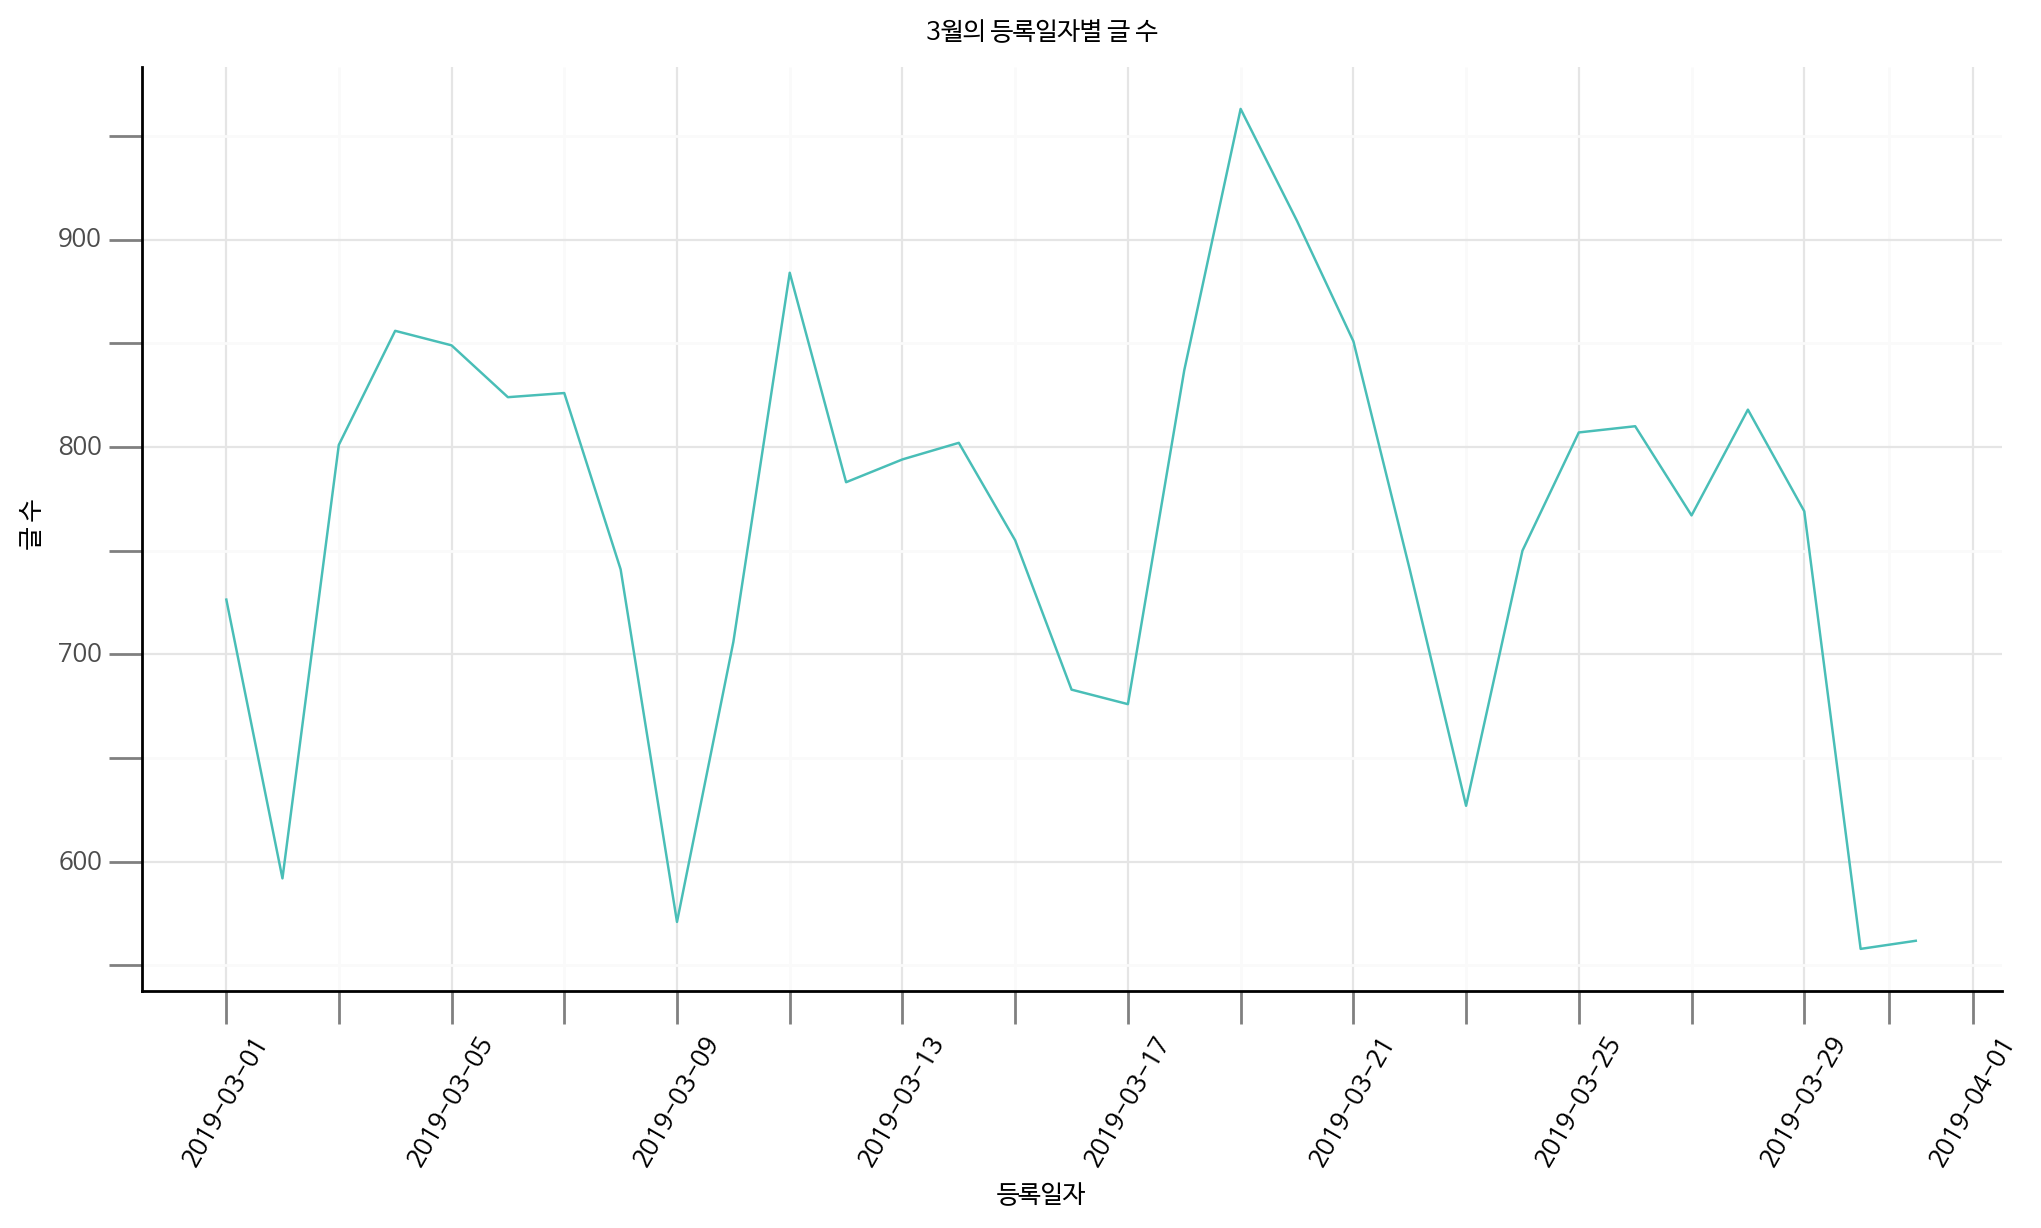

<ggplot: (8730253679349)>

In [27]:
read_cnt_by_reg_dt_ = read_cnt_by_reg_dt[read_cnt_by_reg_dt['reg_dt'] >= '2019-03-01']

(ggplot(data=read_cnt_by_reg_dt_)
    + geom_line(aes(x='reg_dt', y='article_id'), colour = '#49beb7')
    + theme_minimal()
    + ggtitle("3월의 등록일자별 글 수")
    + labs(x="등록일자", y="글 수") 
    + theme(text = element_text(fontproperties=fm.FontProperties(fname=fontpath, size=9)),
         axis_text_x = element_text(angle=60, color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(12,6))
 )

3월의 등록일자별 글 수를 살펴보면 1주일을 주기로 어떤 패턴을 보이는 것 같습니다. 이런 모습을 보이는 이유는 위클리 매거진에 있는데 매주 동일한 날짜에 "브런치에서 선정한 작가가 글을 주기적으로 올리는 매거진"이기 때문입니다. 

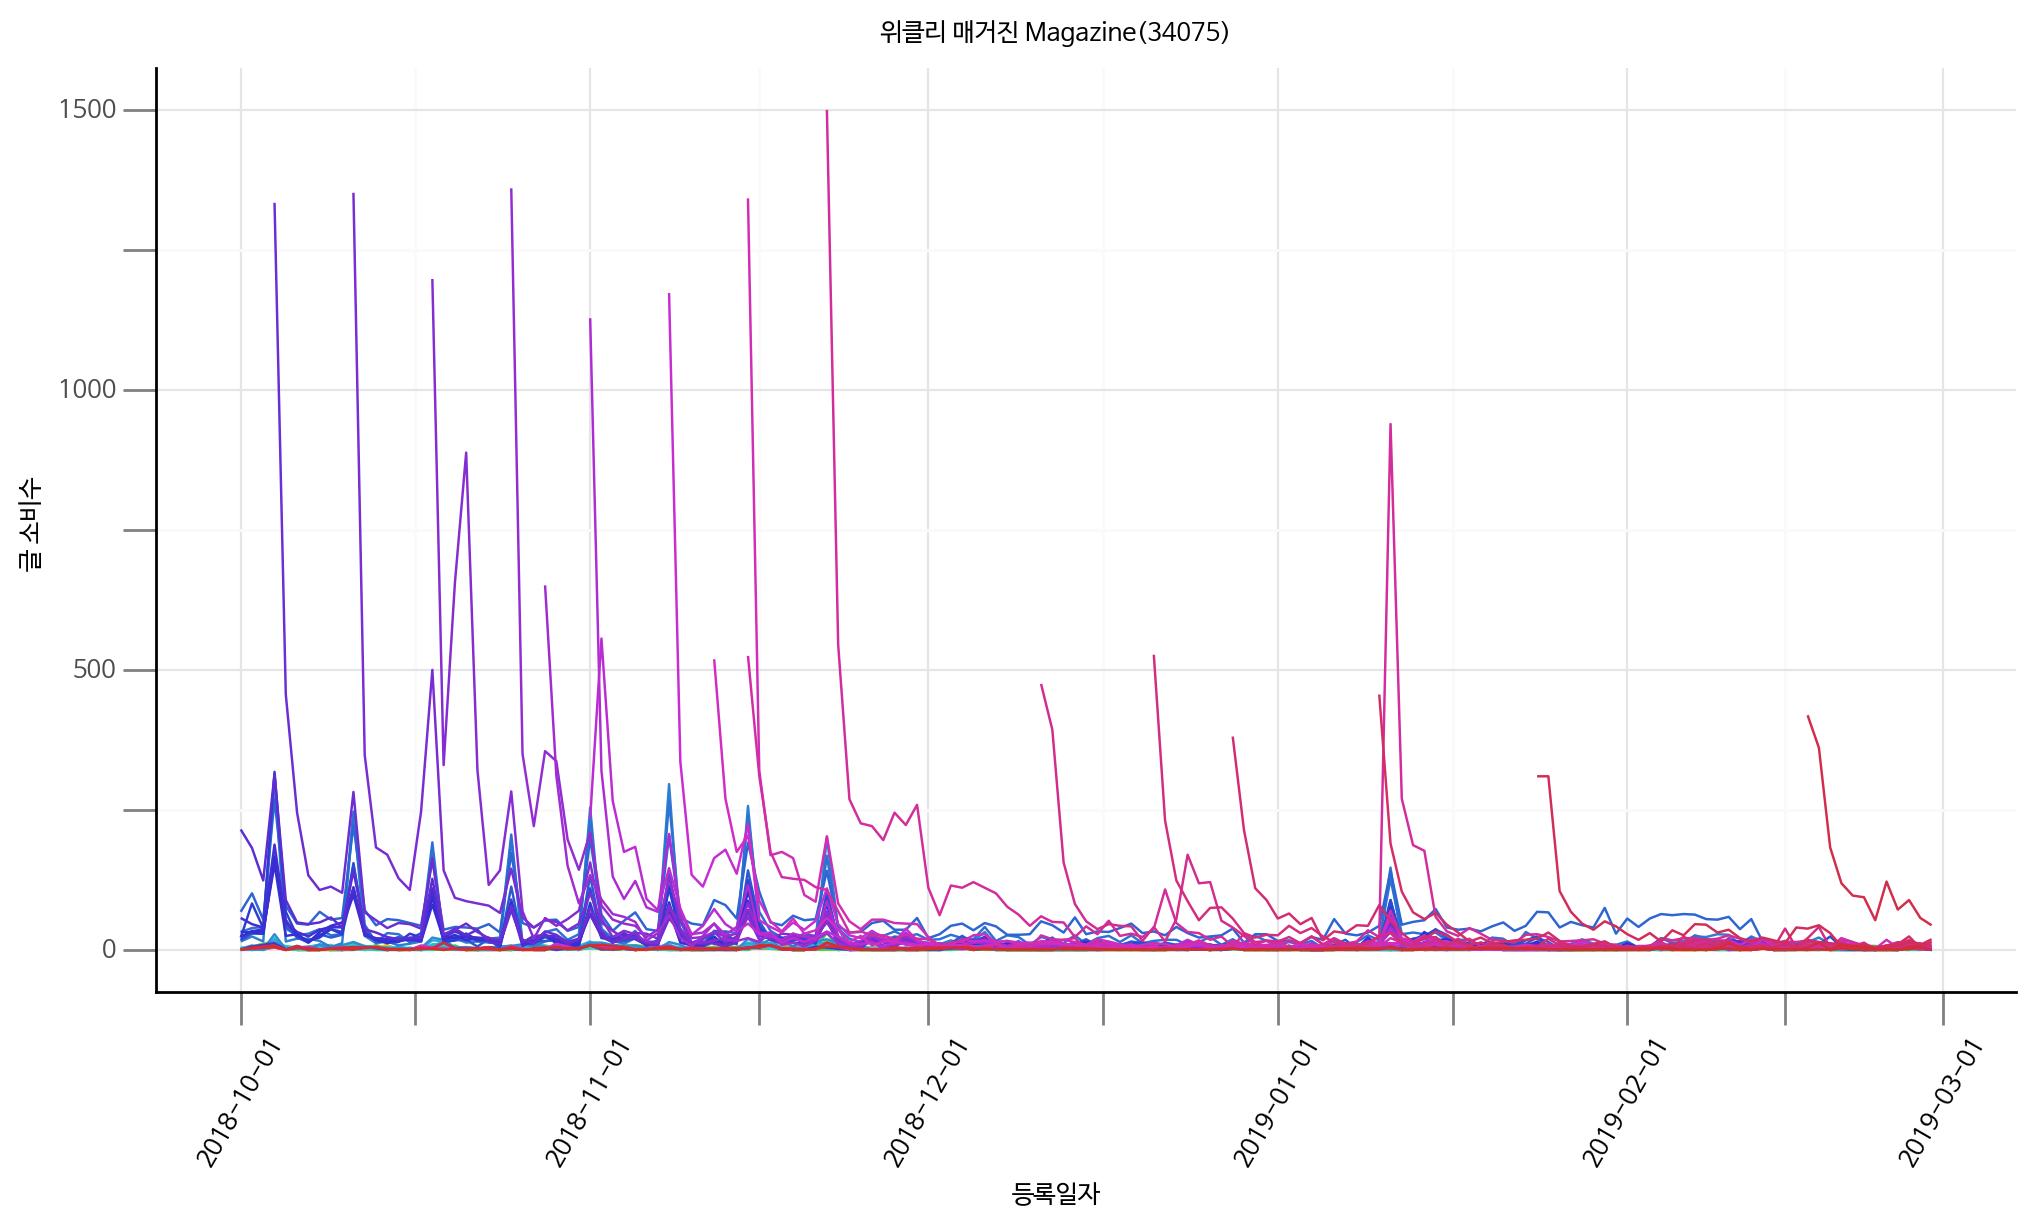

<ggplot: (8730255311245)>

In [28]:
# metadata[metadata['magazine_id'] == 34075]
read_cnt_by_reg_dt = read_rowwise[read_rowwise['author_id'] == '@merryseo'].groupby(['read_dt','article_id'])['article_id'].agg({'count'}).reset_index()
read_cnt_by_reg_dt = read_cnt_by_reg_dt.sort_values(by='read_dt', ascending=False)

(ggplot(data=read_cnt_by_reg_dt)
    + geom_line(aes(x='read_dt', y='count',group='article_id', colour='article_id'), show_legend=False)
    + theme_minimal()
    + ggtitle("위클리 매거진 Magazine(34075)")
    + labs(x="등록일자", y="글 소비수") 
    + theme(text = element_text(fontproperties=fm.FontProperties(fname=fontpath, size=9)),
         axis_text_x = element_text(angle=60, color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(12,6))
    + scale_color_hue(l=0.5)
 )

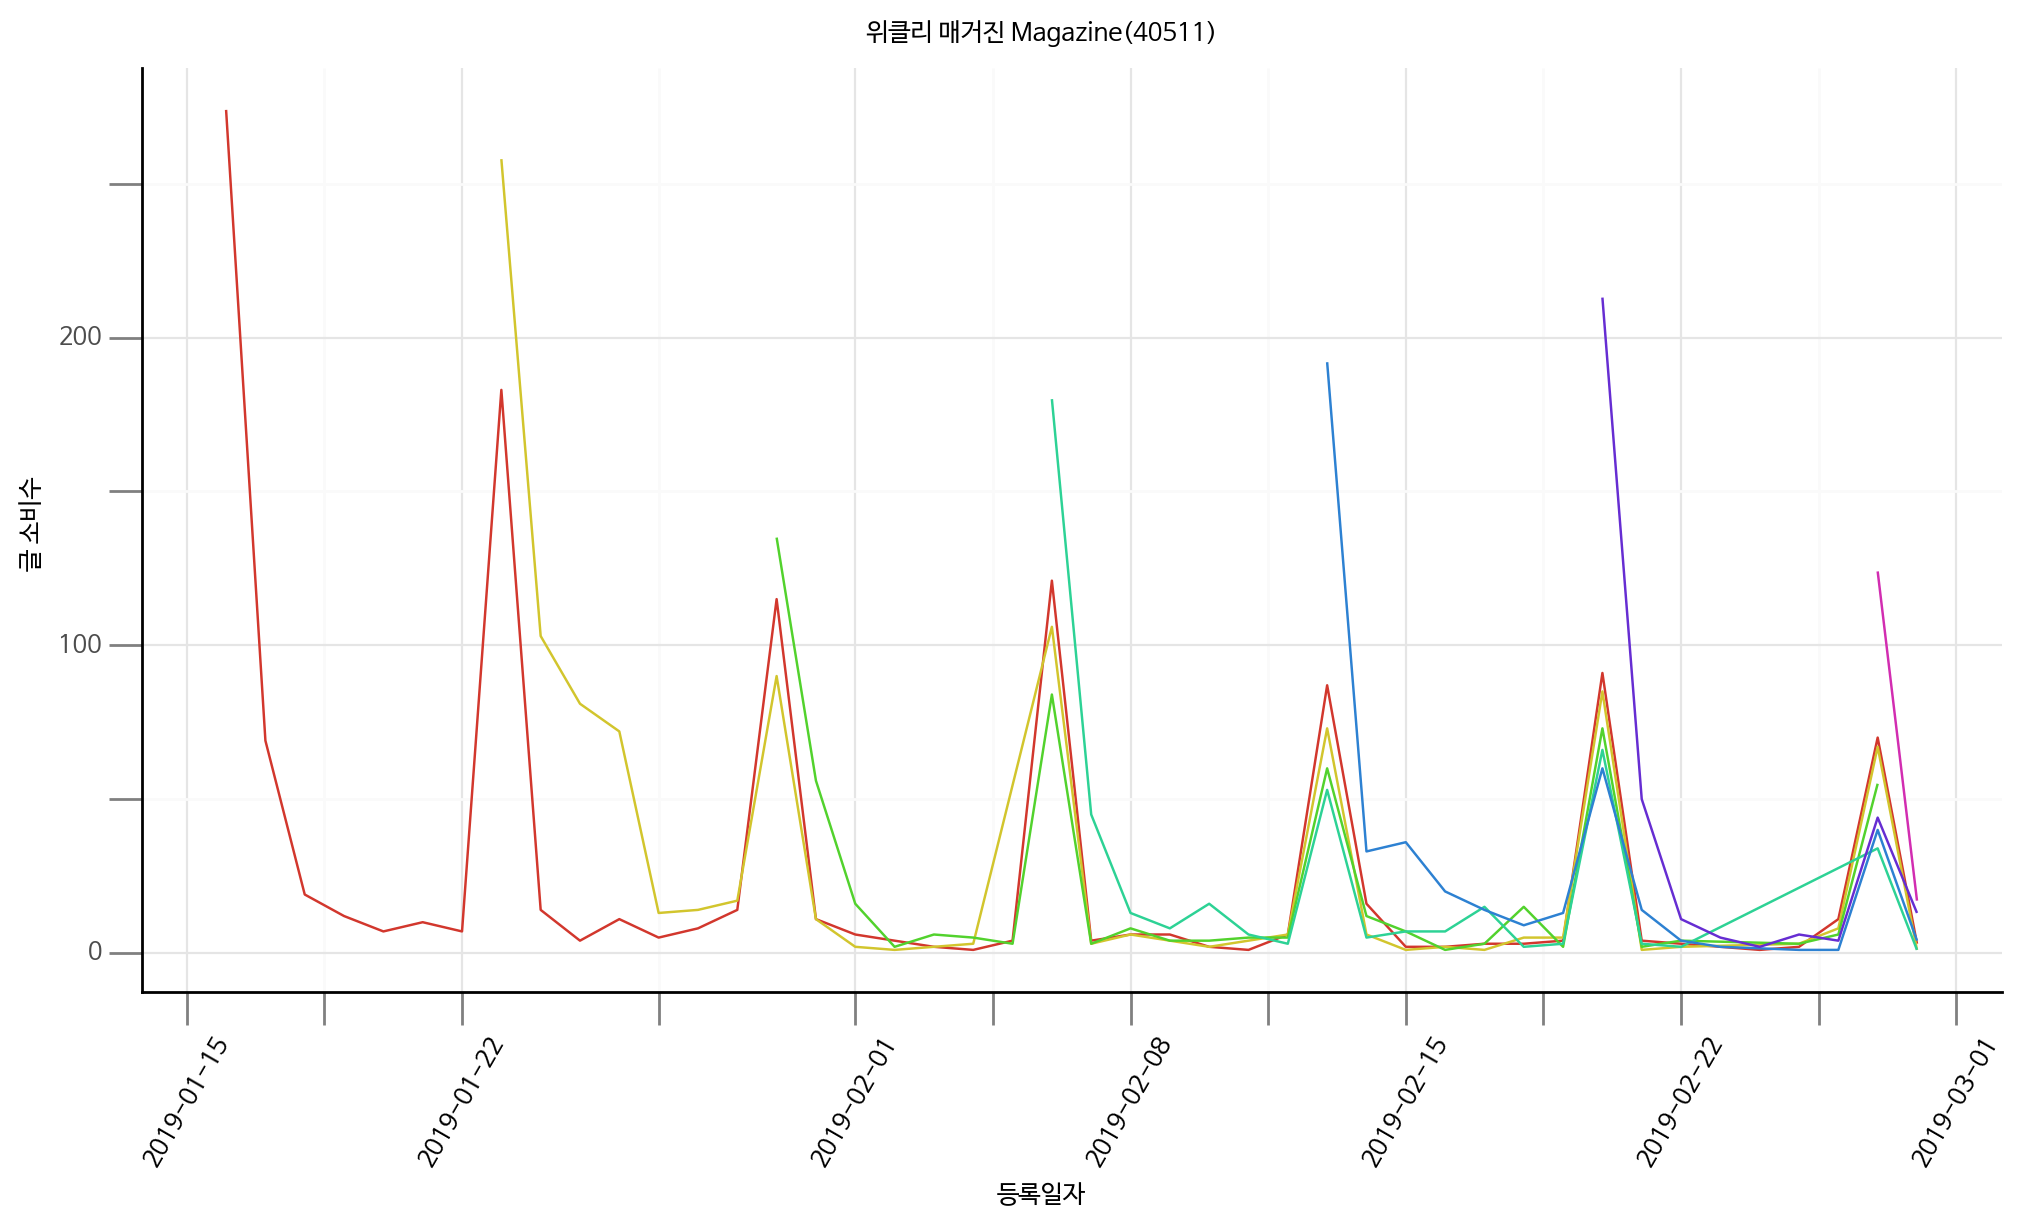

<ggplot: (8730253611093)>

In [29]:
# metadata[metadata['magazine_id'] == 34075]
read_cnt_by_reg_dt = read_rowwise[read_rowwise['author_id'] == '@basenell'].groupby(['read_dt','article_id'])['article_id'].agg({'count'}).reset_index()
metadata_ = metadata[['id', 'reg_dt']].rename(columns={'id':'article_id'})
read_cnt_by_reg_dt = pd.merge(read_cnt_by_reg_dt, metadata_[['article_id', 'reg_dt']], how='left', on='article_id')
read_cnt_by_reg_dt = read_cnt_by_reg_dt[read_cnt_by_reg_dt['reg_dt'] >= '2019-01-15']

(ggplot(data=read_cnt_by_reg_dt)
    + geom_line(aes(x='read_dt', y='count',group='article_id', colour='article_id'), show_legend=False)
    + theme_minimal()
    + ggtitle("위클리 매거진 Magazine(40511)")
    + labs(x="등록일자", y="글 소비수") 
    + theme(text = element_text(fontproperties=fm.FontProperties(fname=fontpath, size=9)),
         axis_text_x = element_text(angle=60, color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(12,6))
    + scale_color_hue(l=0.5)
 )

위클리 매거진에 따른 글 소비수를 **발행과 동시에 엄청난 소비수**를 보이는 것을 알 수 있습니다. 그리고 자세히보면, 일주일 이후에 다시 솟아오르는 모습 또한 볼 수 있는데, 다음편을 보기전에 이전편을 보는 모습을 확인할 수 있습니다. 

In [30]:
# 등록일에 따른 글 소비수의 변화 
read_rowwise = pd.merge(read_rowwise, metadata_, how='left', on='article_id')
read_rowwise['diff_dt'] = (read_rowwise['read_dt'] - read_rowwise['reg_dt']).dt.days
off_day = read_rowwise.groupby(['diff_dt'])['diff_dt'].agg({'count'}).reset_index()

# 메타데이터에 날짜가 잘못 매핑되어서 음수값이 나오는 값 제거 
# 200이하로 뽑은 이유는 날짜가 너무 큰 데이터가 있어서 제거했음 
off_day = off_day[(off_day['diff_dt'] >= 0) & (off_day['diff_dt'] <= 200)]

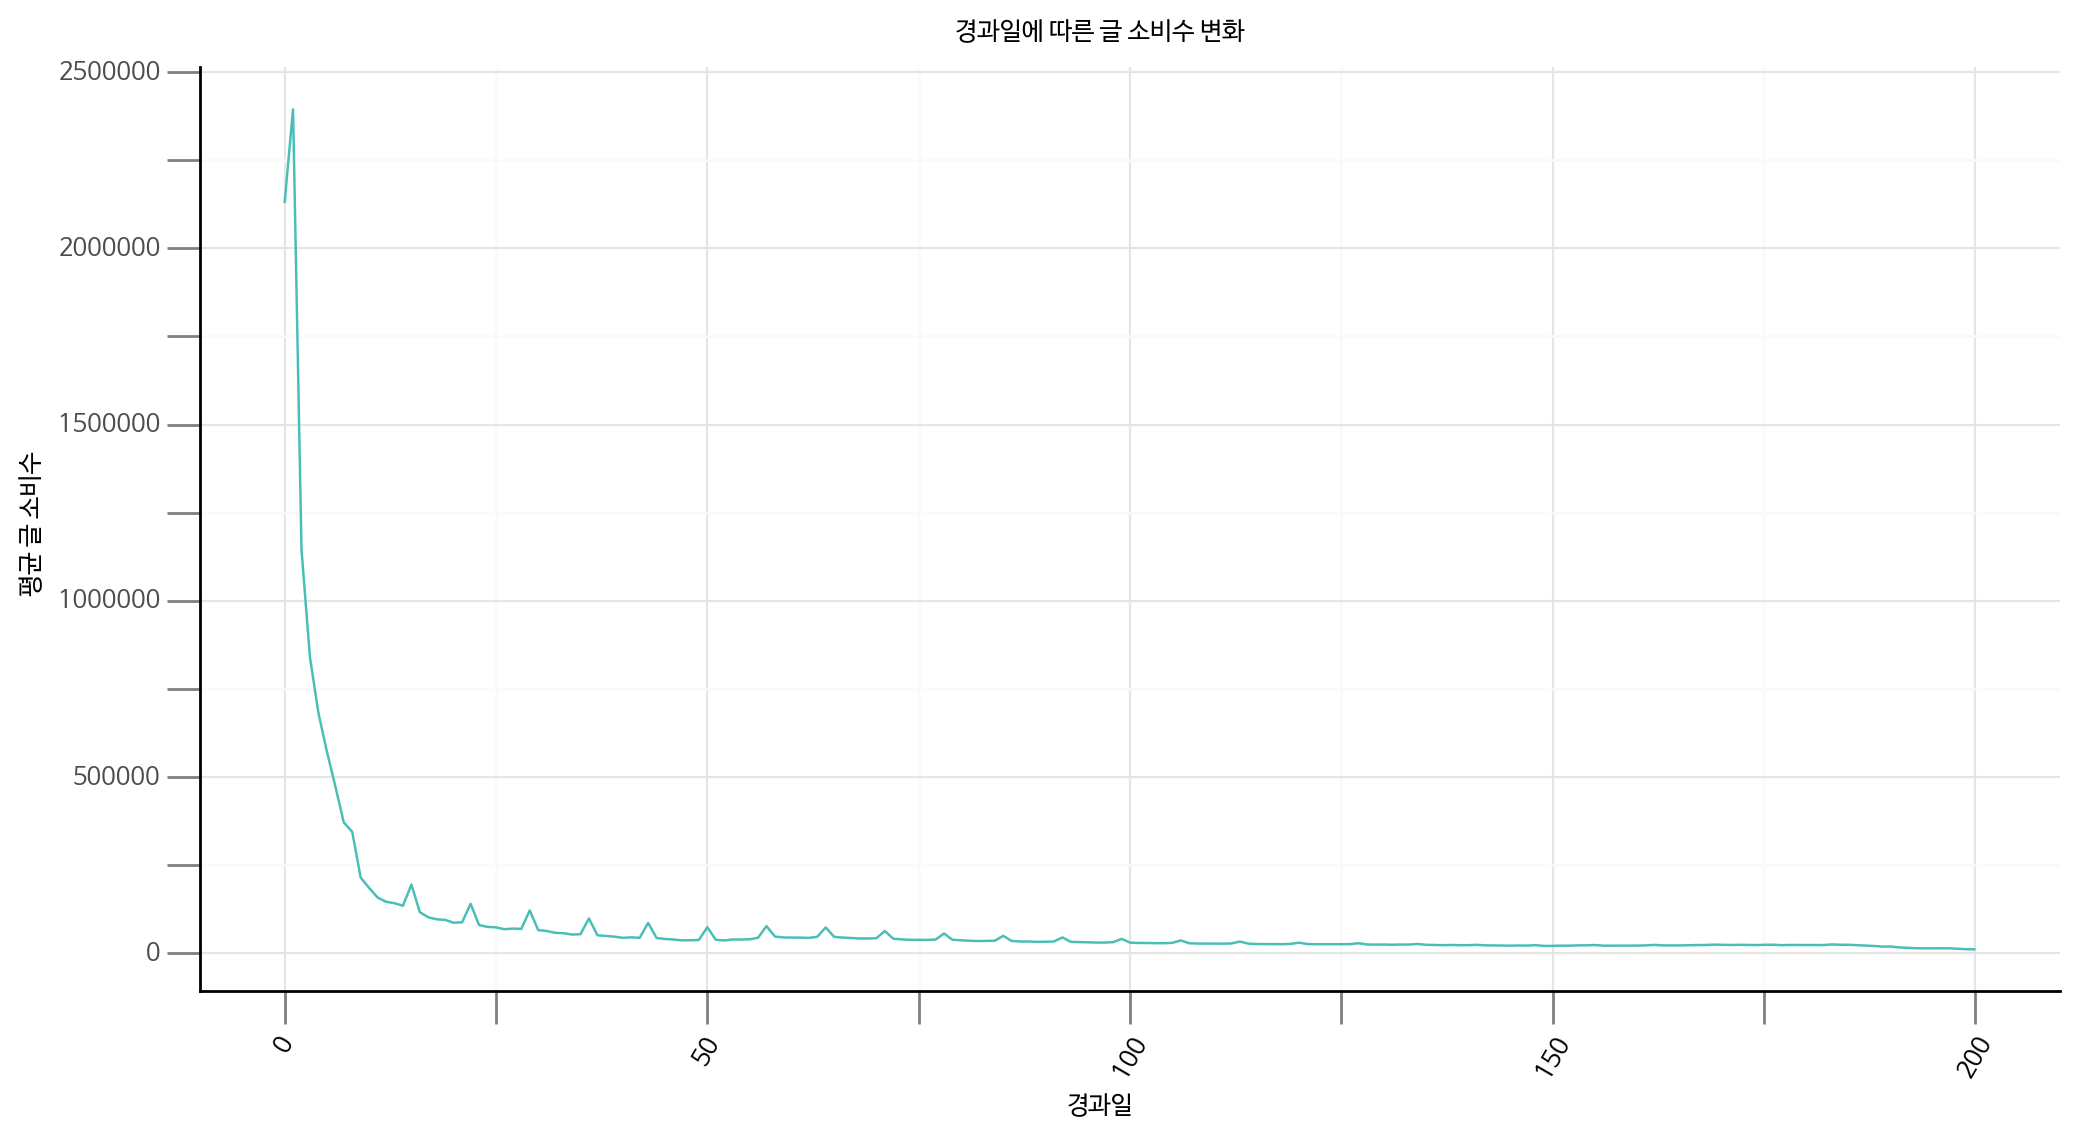

<ggplot: (8730253612837)>

In [31]:
(ggplot(data=off_day)
    + geom_line(aes(x='diff_dt', y='count'), color='#49beb7')
    + theme_minimal()
    + ggtitle("경과일에 따른 글 소비수 변화")
    + labs(x="경과일", y="평균 글 소비수") 
    + theme(text = element_text(fontproperties=fm.FontProperties(fname=fontpath, size=9)),
         axis_text_x = element_text(angle=60, color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(12,6))
    + scale_color_hue(l=0.5)
 )

In [32]:
metadata['keyword_list'].values[0]

['여행', '호주', '국립공원']

In [33]:
keyword_dict = {}
for i in tqdm_notebook(metadata[metadata['keyword_list'].apply(lambda x: len(x)) != 0]['keyword_list'].values):
    for j in range(0, len(i)):
        word = i[j]
        cnt = 1
        try:
            keyword_dict[word] += cnt
        except:
            keyword_dict[word] = cnt

In [34]:
# wordcloud에 대한 자세한 정보는 lovit님의 블로그 https://lovit.github.io/nlp/2018/04/17/word_cloud/를 참고하시기 바랍니다. 
from wordcloud import WordCloud
from PIL import Image

wordcloud = WordCloud(
    font_path = fontpath,
    width = 800,
    height = 800,
    background_color="white",
    mask= np.array(Image.open(path + "/figure/RS-KR.png"))

)
wordcloud = wordcloud.generate_from_frequencies(keyword_dict)

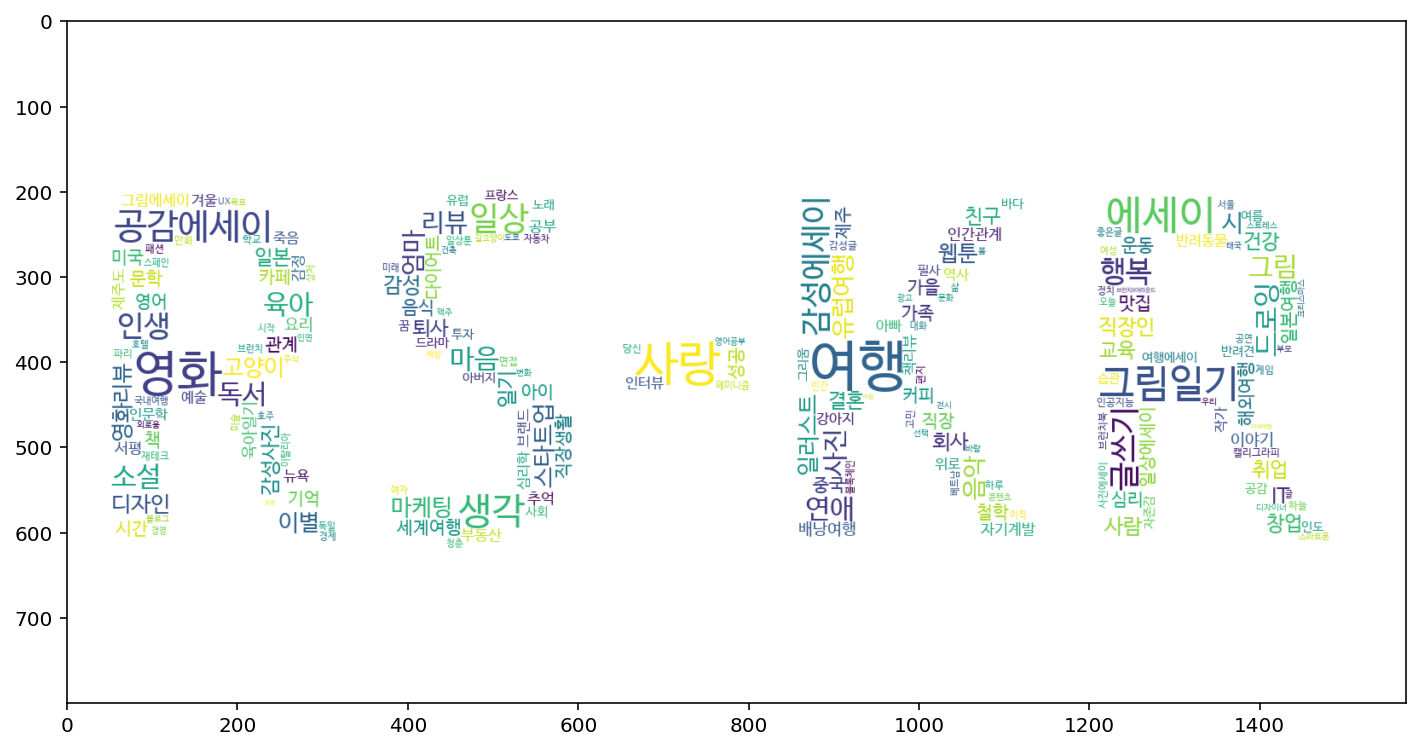

In [35]:
fig = plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()
fig.savefig('wordcloud2.png')

참고자료 
- 브런치 데이터의 탐색과 시각화 : https://brunch.co.kr/@kakao-it/332
- Kakao Arena 2회 대회 : 브런치 사용자를 위한 글 추천 대회 : https://arena.kakao.com/forum/topics/10